## 以下テンプレート

In [2]:
# 表示用
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook

In [3]:
import numpy as np
from numpy import zeros, newaxis
import datetime
import os
import copy
import time

# Parametor about Sensor
SensorNum=1 # Sensor number
#SensorAxis='AccX' # Axis

# Parametor about  " Sliding Window " 
WindowWidth =np.array([128,256,512,1024,2048,4096]) # Window Width
SlidingWidth =WindowWidth/4 #sliding window

# Parametor about Neural Network
AEDimention = 16

# Define Data Name
DATE= str( datetime.date.today() )+'/'
TITLE="Participants01_First_1/"

# Parametor about " Data Path"
DataPath = "/media/takeyama/Transfer/02_ActivityResearch/Paticipants01/01_First/20161018-105301/mem/"

#chopin
#StorePath = "/home/takeyama/Documents/"
#mozart
StorePath ="/media/takeyama/HD-PNFU3/01_ActivityResearchData/"
if not os.path.exists(StorePath+TITLE+'dictionary/'): 
    os.makedirs(StorePath+TITLE+'dictionary/')
DictionaryDataPath=StorePath+TITLE+'dictionary/'

if not os.path.exists(StorePath+TITLE+'window/'): 
    os.makedirs(StorePath+TITLE+'window/')
WindowDataPath=StorePath+TITLE+'window/'

if not os.path.exists(StorePath+TITLE+DATE+'studyOutput/'): 
    os.makedirs(StorePath+TITLE+DATE+'studyOutput/')
StudyOutputPath=StorePath+TITLE+DATE+'studyOutput/'

if not os.path.exists(StorePath+TITLE+DATE+'parametor/'): 
    os.makedirs(StorePath+TITLE+DATE+'parametor/')
ParametorPath=StorePath+TITLE+DATE+'parametor/'

if not os.path.exists(StorePath+TITLE+DATE+'result/'): 
    os.makedirs(StorePath+TITLE+DATE+'result/')
ResultPath=StorePath+TITLE+DATE+'result/'

if not os.path.exists(StorePath+'/'+TITLE+DATE+'graph/'): 
    os.makedirs(StorePath+'/'+TITLE+DATE+'graph/')
GraphPath=StorePath+'/'+TITLE+DATE+'graph/'

センサデータの読み込み

In [4]:
# センサデータのcsvファイル名をリストに集約する関数
def SensorDataFileNameList(path):
    l = os.listdir(DataPath)
    FilePath =[]
    SensorName = []
    
    for n in range(len(l)):
        if (l[n][:4].find('mem-') != -1):
            FilePath.append(l[n])
            SensorName.append(l[n][4:15])
    
    return FilePath,SensorName

CSVを読み込んで，CSVの中身を辞書型で表現する

In [5]:
def ImportCSV(csv_file,SensorName,mode='Round'):
    import pandas as pd
    '''
    ~Argument~
    csv_file -> ファイル名 
    mode Round -> 四捨五入
         Roundup -> 切り上げ
         Rounddown -> 切り捨て
    
    ~Conversion~
    Acc Data  [0.1mG]=>[G]
    Gyr Data  [0.01dps]=>[dps]   ...dps=degree per second
    '''
    # data dictionary 
    RawData={}   
    AccConversion = 0.1 * 0.001
    GyrConversion = 0.01
    
    # design dataframe and import csv
    data = pd.read_csv(csv_file)
    data.columns=[u'Type',u'Time',u'AccX',u'AccY',u'AccZ',u'GyrX',u'GyrY',u'GyrZ']
    data = data[ data['Type']=='ags']

    # convert numpy.darray 

    AccX=data.AccX.values*AccConversion
    AccY=data.AccY.values*AccConversion
    AccZ=data.AccZ.values*AccConversion
    
    GyrX=data.GyrX.values*GyrConversion
    GyrY=data.GyrY.values*GyrConversion
    GyrZ=data.GyrZ.values*GyrConversion

    # regist each raw data 
    RawData['AccX'] = AccX
    RawData['AccY'] = AccY
    RawData['AccZ'] = AccZ
    RawData['GyrX'] = GyrX
    RawData['GyrY'] = GyrY
    RawData['GyrZ'] = GyrZ
    RawData['Name'] = SensorName

    RawData['Time'] = data.Time.values

    return RawData

In [6]:
# FFT library
from scipy import fftpack
from scipy import signal

# Graph Plot
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Generate WindowFrame Function
from mymodule import window

# timer
import time

%matplotlib inline

In [7]:
DictName=os.listdir(DictionaryDataPath)

In [8]:
Sensor1 = np.load(DictionaryDataPath+DictName[0])['data'][()]
Sensor2 = np.load(DictionaryDataPath+DictName[1])['data'][()]
Sensor3 = np.load(DictionaryDataPath+DictName[2])['data'][()]
Sensor4 = np.load(DictionaryDataPath+DictName[3])['data'][()]
Sensor5 = np.load(DictionaryDataPath+DictName[4])['data'][()]
Sensor6 = np.load(DictionaryDataPath+DictName[5])['data'][()]

グラフプロットする

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def MakingGraphPath(p):
    if not os.path.exists(GraphPath+p): 
        os.makedirs(GraphPath+p)
    ThisGraphPath=GraphPath+p
    return ThisGraphPath

In [11]:
def GetWindowFrame(windowName, dataRaw, wWidth, sWidth, PATH):
    """
    data　ウィンドウフレームに変換するデータ
    registName　ウィンドウフレームに登録するデータの名前
    windowWidth　ウィンドウ幅
    slidingWidth　スライド幅
    PATH ウィドウフレームを保存するディレクトリ
    
    
    About Function:
        与えられたdataからウィンドウ幅windowWidth,スライド幅slidingWidthにしたがって
        registNameのウィドウフレームを返す．
        また，与えれたPATH内に同様なパラメータ( WindowWidth, slidingWidth)かつ同様な
        windowNameのものがある場合，そのデータを返す．
        この関数が登録，ウィンドウフレームに変換できるデータは１つとする
    """
    storedName = windowName+'_Win='+str(wWidth).zfill(4)+'_Sld='+str(sWidth).zfill(4)+'.npz'
    l = os.listdir(PATH)
    
    if storedName in l:
        print "this data had finished making"
        return np.load(PATH+storedName)['data'][()]
    
    w=window()
    w.SetData(windowName,dataRaw)    
    wind=w.Compile(wWidth,sWidth)
    windoW=wind.reshape((len(wind),np.prod(wind.shape[1:])))
    
    np.savez(PATH+storedName,data=wind)

    return wind

## 本スクリプトの目的および生成していくもの
基本的には，**ウィンドウフレームごと**の特徴を生成する
まず，ウィンドウフレームの設定を明記する
* window幅 = 256,512,1024,2048,4096
* スライド幅はwindow幅の8分の1に固定する

そして，生成していくものはタイトルのように時間領域の波形のMathmatical/Statisticalデータを出す
つまり，ウィンドウフレームごとの平均や分散，中央値のような統計量，RMS,Correlation,Cross-Correlationを出す


# 以下，センセー１の加速度Xを用いる



In [12]:
windowNum = 256
slidingNum = windowNum/32

wind=GetWindowFrame('AccX', Sensor1['AccX'], windowNum, slidingNum, WindowDataPath)

this data had finished making


ウィンドウフレームごとのグラフ

In [15]:
wind.shape

(134702, 256)

In [18]:
wind[0,:].mean()

0.99480742187500004

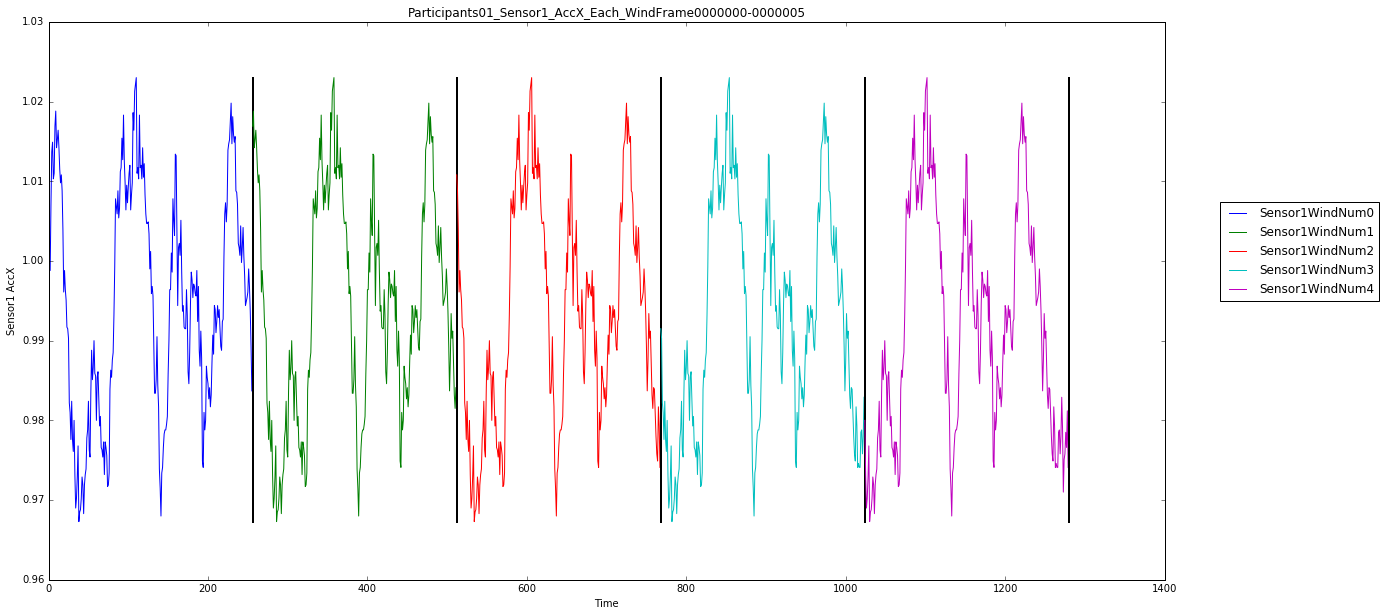

In [ ]:
%%timeit
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('Time')
ax.set_ylabel('AccX')


ThisGraphPath = MakingGraphPath('Sensor1/Wave_AccX_windowNum='+str(windowNum).zfill(4)\
                                +'_slidingNum='+str(windowNum).zfill(4)+'/')

RngPlotWidth = 5
for RngPlotStart in tqdm_notebook(xrange(0,wind.shape[0],RngPlotWidth)):
    for i in range(0,RngPlotWidth):
        MIN = wind[RngPlotStart+i,:wind.shape[1]].min()
        MAX = wind[RngPlotStart+i,:wind.shape[1]].max()
        ax.plot(range(i*wind.shape[1],(i+1)*wind.shape[1]), wind[RngPlotStart+i,:wind.shape[1]],label='Sensor1'+'WindNum'+str(i))
        ax.plot([(i+1)*wind.shape[1], (i+1)*wind.shape[1]], [MIN,MAX], 'k-', lw=2)
    
    lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

    ax.set_title("Participants01_Sensor1_AccX_Each_WindFrame"+str(RngPlotStart).zfill(7)+\
                 '-'+str(RngPlotStart+RngPlotWidth).zfill(7))
    ax.set_ylabel("Sensor1 AccX")

    filename = "Participants01_Sensor1_AccX_Each_WindFrame"+str(RngPlotStart).zfill(5)+\
    '-'+str(RngPlotStart+RngPlotWidth).zfill(5)+".png"
    ax.figure.savefig(ThisGraphPath+filename,bbox_extra_artists=(lgnd,), bbox_inches='tight')

    plt.show()
    
    ax.clear()
    time.sleep(0.01)

次は，平均をグラフ化してみる

In [26]:
MeanArray.shape

(50,)

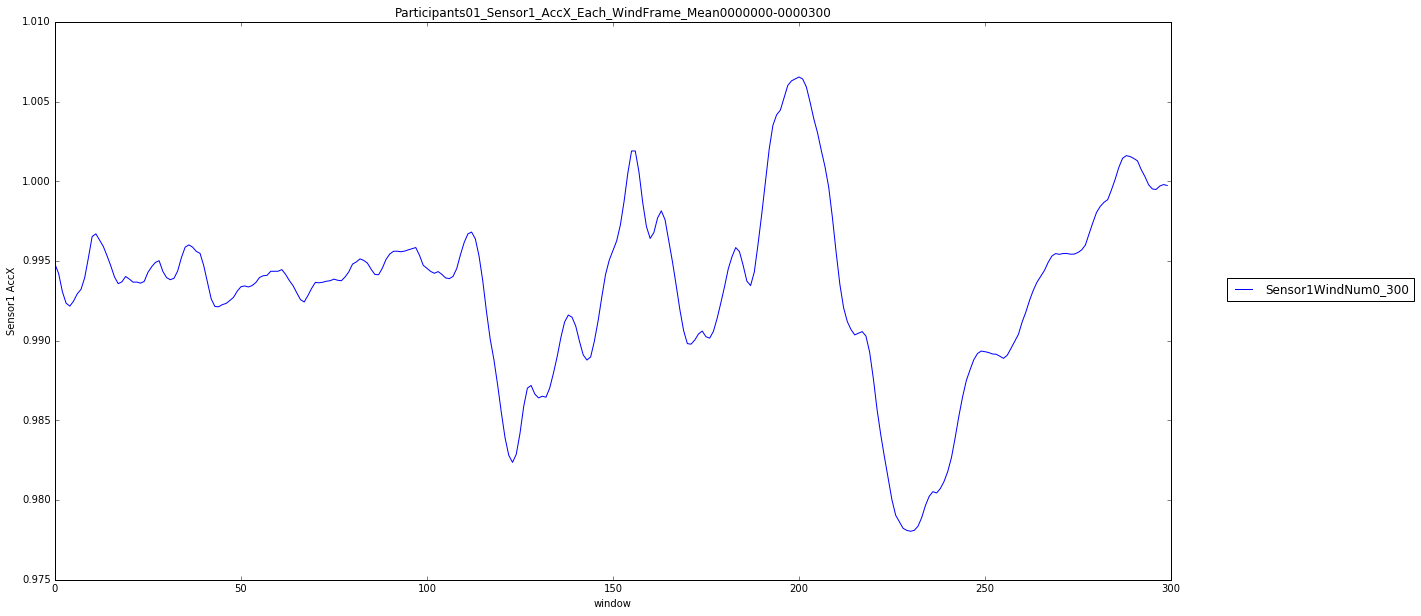

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/takeyama/.pyenv/versions/2.7.11/lib/python2.7/threading.py", line 801, in __bootstrap_inner
    self.run()
  File "/home/takeyama/.pyenv/versions/2.7.11/envs/takeyama/src/tqdm/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/home/takeyama/.pyenv/versions/2.7.11/envs/takeyama/lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



In [28]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.set_xlabel('window')
ax.set_ylabel('AccX')


ThisGraphPath = MakingGraphPath('Sensor1/Mean_AccX_windowNum='+str(windowNum).zfill(4)\
                                +'_slidingNum='+str(windowNum).zfill(4)+'/')

RngPlotWidth = 300

for RngPlotStart in tqdm_notebook(xrange(0,wind.shape[0],RngPlotWidth)):
    MeanArray = np.array([])
    for i in range(0,RngPlotWidth):
        MeanArray = np.append(MeanArray, wind[i,:].mean() )
        
    ax.plot(range(0,RngPlotWidth), MeanArray,\
            label='Sensor1'+'WindNum'+str(RngPlotStart)+'_'+str(RngPlotStart+RngPlotWidth))

    lgnd=ax.legend(bbox_to_anchor=(1.05, 0.5), loc='lower left', borderaxespad=0)

    ax.set_title("Participants01_Sensor1_AccX_Each_WindFrame_Mean"+str(RngPlotStart).zfill(7)+\
                 '-'+str(RngPlotStart+RngPlotWidth).zfill(7))
    ax.set_ylabel("Sensor1 AccX")

    filename = "Participants01_Sensor1_AccX_Each_WindFrame_Mean"+str(RngPlotStart).zfill(5)+\
    '-'+str(RngPlotStart+RngPlotWidth).zfill(5)+".png"
    ax.figure.savefig(ThisGraphPath+filename,bbox_extra_artists=(lgnd,), bbox_inches='tight')

    plt.show()
    
    ax.clear()
    time.sleep(0.01)

In [13]:
wind.shape

(134702, 256)

In [14]:
Sensor1['AccX'].shape

(1077870,)

In [15]:
Sensor1['AccX'].size

1077870

In [16]:
Sensor1['AccX'].ndim

1

In [17]:
windowNum/32

8